In [7]:
# 挂载 google 云盘
from google.colab import drive
drive.mount('/content/gdrive')

# 将文件路径指定为数据路径
import os
os.chdir('/content/gdrive/My Drive/comment')

import numpy as np
import pandas as pd

from tqdm import tqdm #显示运行进度条

# 画图库
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
import matplotlib.pyplot as plt

# 文字处理库
from keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
# nltk.download('stopwords') #下载停止词
import string
from keras.preprocessing import sequence
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
nltk.download('stopwords') #下载停止词
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
labels = train_data.columns[2:].tolist()
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
all_comments = pd.concat([train_data['comment_text'], test_data['comment_text']])
stop_words = set(stopwords.words('english'))
stop_words.update(string.punctuation)
comments_refined = []
for line in tqdm(all_comments):
    comments_refined.append(' '.join([word for word in tokenizer.tokenize(line) if word not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


100%|██████████| 312735/312735 [00:09<00:00, 31384.89it/s]


In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    analyzer='word',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True,
    max_features=50000
#     max_features=10000
    ).fit(comments_refined)
train_features, test_features = map(lambda x: vectorizer.transform(x), 
                                    [train_data['comment_text'], test_data['comment_text']] )



100%|██████████| 6/6 [03:42<00:00, 36.97s/it]


Total CV score is 0.9804291093517062


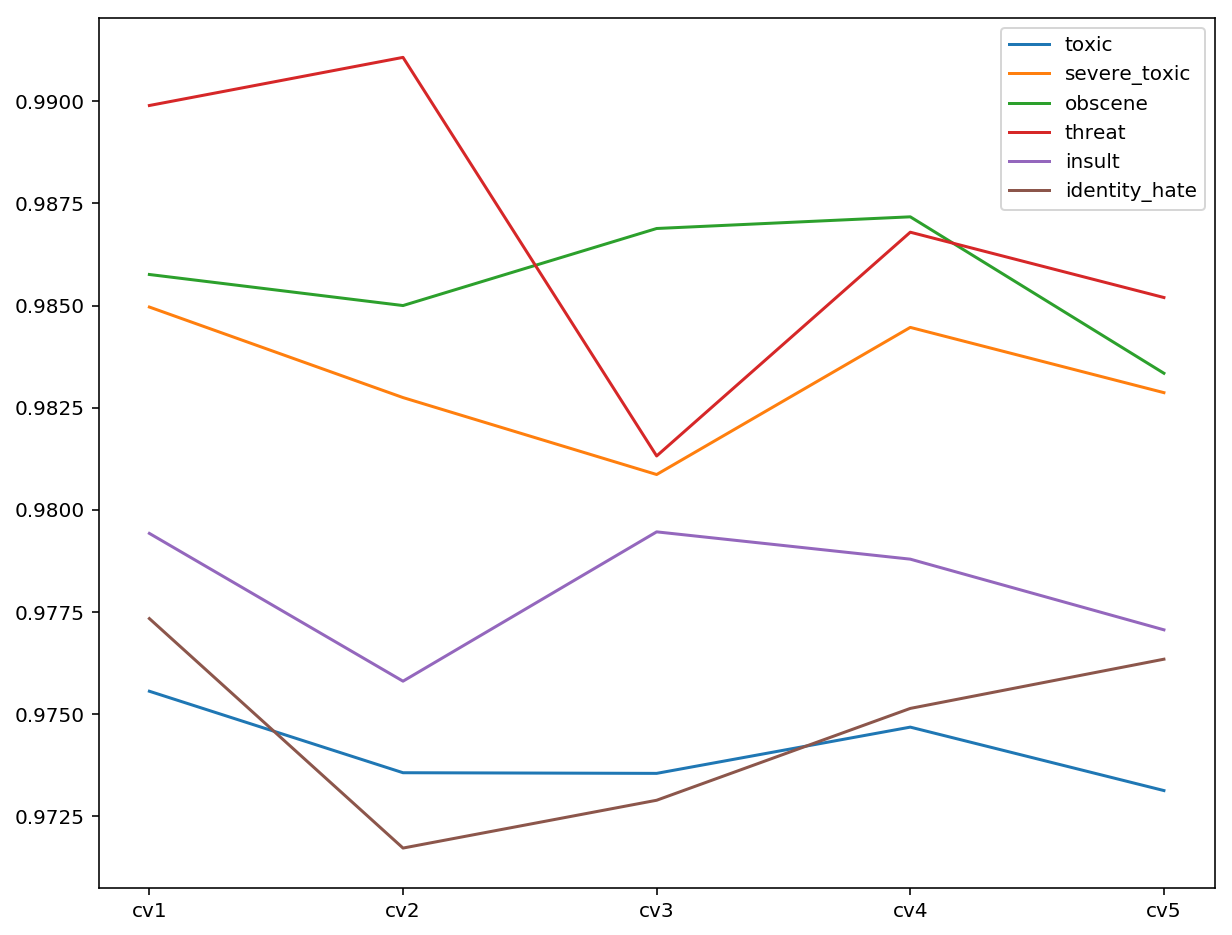

In [4]:
# from sklearn.tree import DecisionTreeClassifier
cv_scores = []
submission = pd.DataFrame.from_dict({'id': test_data['id']})
for label in tqdm(labels):
    classifier = LogisticRegression(C=4,solver='sag')
    cv_scores.append(cross_val_score(  classifier, 
                                       train_features, 
                                       train_data[label], 
                                       cv=5, 
                                       scoring='roc_auc'))
    classifier.fit(train_features, train_data[label])
    submission[label] = classifier.predict_proba(test_features)[:, 1]

print('Total CV score is {}'.format(np.mean(cv_scores)))
plt.figure(figsize=[10,8])
for score in cv_scores:
  plt.plot(['cv1','cv2','cv3','cv4','cv5'], score)
plt.legend(labels, loc='upper right')
submission.to_csv('submission_simple.csv', index=False)